In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import math

### A linear Poisson equation
$\nabla^2 u = sin(\pi x) sin(\pi y)$ \
$0 \leq x \leq 1$ \
$0 \leq y \leq 1$

### Problem specific functions / variables

In [2]:
# partial differential equation
def f(x):
    return torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

def L(model, x):
    y = model(x.float())
    y_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    y_xx = torch.autograd.grad(y_x, x, grad_outputs=torch.ones_like(y_x),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    return torch.sum(y_xx, -1)

# boundary conditions
def g(x):
    return torch.zeros(x.size()[0])

def B(model, x):
    return model(x.float())[:,0]

# Quadrature

xs = torch.linspace(0, 1, steps=10, requires_grad=True)
ys = torch.linspace(0, 1, steps=10, requires_grad=True)
x,y = torch.meshgrid(xs, ys)
w = torch.cat((torch.reshape(x, (1,-1)), torch.reshape(y,(1,-1))), 0).T

dw = []
for xy in w:
    if xy[0] == 0 or xy[1] == 0 or xy[0] == 1 or xy[1] == 1:
        dw.append(xy)
dw = torch.stack(dw)

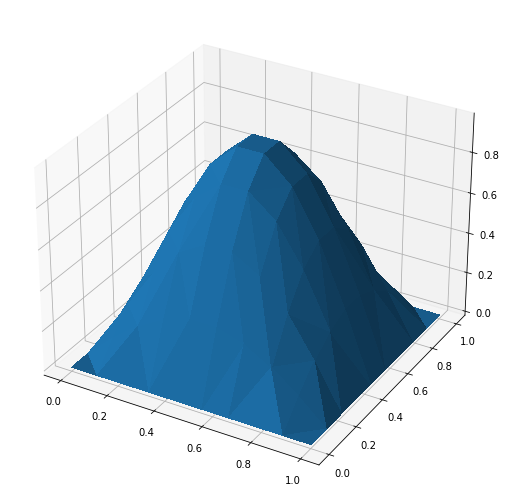

In [3]:
# Creating dataset
z = f(w)
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

xs_plt = w[:,0].detach().numpy()
ys_plt = w[:,1].detach().numpy()
zs_plt = z.detach().numpy()

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, zs_plt, linewidth=0, antialiased=False)
plt.show()

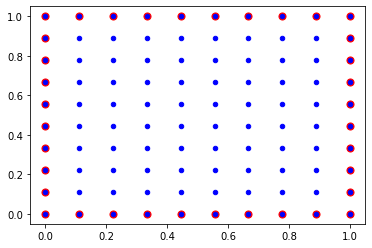

In [4]:
dxs_plt = dw[:,0].detach().numpy()
dys_plt = dw[:,1].detach().numpy()

plt.scatter(dxs_plt,dys_plt, c = 'r', s = 50)
plt.scatter(xs_plt,ys_plt, c = 'b', s = 20)
plt.show()
# add proper pyplot defualts

### Loss function

In [20]:
def h(model, w_, dw_):
    df = L(model, w_) - f(w_)
    dg = B(model, dw_) - g(dw_)
    loss = torch.sum(torch.square(df)) + 0.5 * torch.sum(torch.square(dg))
    return loss

### Neural Network

In [21]:
class MyFunction(nn.Module):
    def __init__(self,input_size=2,output_size=1):
        super(MyFunction, self).__init__()
        self.linear1 = nn.Linear(input_size,5)
        self.linear2 = nn.Linear(5,5)
        self.linear3 = nn.Linear(5,output_size)

    def forward(self,x):
        z = torch.sigmoid(self.linear1(x))
        z = torch.sigmoid(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z

pdeApprox = MyFunction()

### Training loop

In [22]:
optimizer = torch.optim.Adam(pdeApprox.parameters(), lr=0.001)

#train the neural network for 5 epochs
for epoch in range(10001):      
    #reset gradients
    optimizer.zero_grad()
        
    #calculate the loss
    loss = h(pdeApprox, w, dw)
    if epoch % 500 == 0:
        print("Epoch: {e} - Loss: {l}".format(e=epoch, l=loss.item()))
        
    #backpropagation
    loss.backward(retain_graph=True)
    
    #update the parameters
    optimizer.step()

Epoch: 0 - Loss: 26.00958251953125
Epoch: 500 - Loss: 16.743478775024414
Epoch: 1000 - Loss: 8.215025901794434
Epoch: 1500 - Loss: 7.544137477874756
Epoch: 2000 - Loss: 5.846602439880371
Epoch: 2500 - Loss: 3.290492057800293
Epoch: 3000 - Loss: 2.1409835815429688
Epoch: 3500 - Loss: 1.3792988061904907
Epoch: 4000 - Loss: 1.216368317604065
Epoch: 4500 - Loss: 1.1691616773605347
Epoch: 5000 - Loss: 1.1103708744049072
Epoch: 5500 - Loss: 0.9755722880363464
Epoch: 6000 - Loss: 0.7741358876228333
Epoch: 6500 - Loss: 0.6070795059204102
Epoch: 7000 - Loss: 0.3946889638900757
Epoch: 7500 - Loss: 0.3153453469276428
Epoch: 8000 - Loss: 0.2852315902709961
Epoch: 8500 - Loss: 0.26171040534973145
Epoch: 9000 - Loss: 0.24254366755485535
Epoch: 9500 - Loss: 0.2269759327173233
Epoch: 10000 - Loss: 0.21362319588661194


### Neural Network Approximation

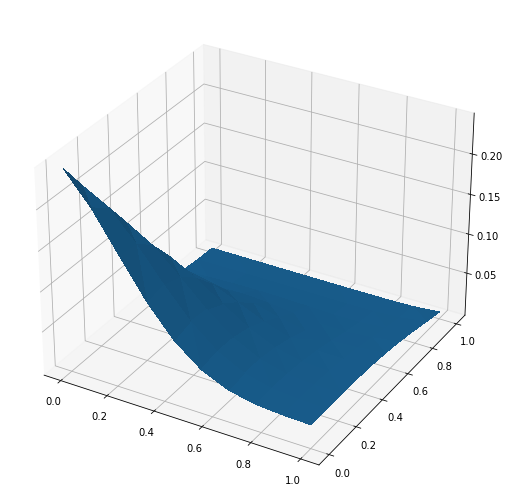

In [24]:
# Creating dataset
pred = pdeApprox(w)[:,0].detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, pred, linewidth=0, antialiased=False)
plt.show()

### Analytical Solution

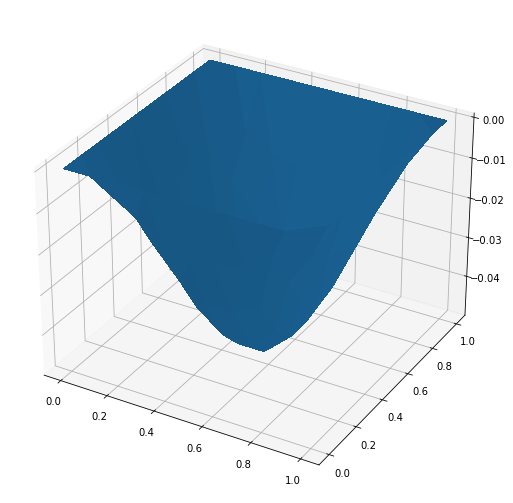

In [25]:
def analytical(x):
    return - 1 / (2 * torch.tensor(math.pi) ** 2) * torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

# Creating dataset
solution = analytical(w).detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, solution, linewidth=0, antialiased=False)
plt.show()